# Music Classification Using Supervised and Unsupervised ML Models
The goal of this project is to develop a few different machine learning models to compare and contrast their ability to classify music into certain genres. To train these models, I will be using the GTZAN Genre Collection (https://www.kaggle.com/datasets/carlthome/gtzan-genre-collection). The models I will train in this project include K-Means, a support vector machine, and a naive bayes classifier.

Music genre classification is a complex problem and even certain humans will disagree with genre classification. It is difficult to describe what attributes qualify a song as a member of one genre vs another. Among the models I have chosen, we can make some predictions about performance before I actually build any models.

K-Means (unsupervised):
- Should be relatively fast compared to the other models.
- The assumption of spherical clusters might not translate very well to the complex features that music is made of.
- Euclidean distance metric might perform poorly, but could maybe be improved using cosine similarity for example. I'll experiment with this.
- This model will likely have the worst performance.

SVM (supervised):
- Works very well for high-dimensional data.
- Might handle non-linearly separable data using kernel tricks. I'll experiment with different kernels to see which works best.
- May be sensitive to hyperparameter tuning.

Naive bayes (supervised):
- Simple model, computationally fast.
- Assumption of feature independence may not be valid for audio data (things like timbre and rhythm may be correlated).

Overall, I expect the SVM model to work the best, but it will be interesting to see how each model performs. I will do some hyperparameter tuning for certain models to see how good I can make these classifiers. I'll discuss each model in its own section to describe any tuning done.

# Data Description/EDA
The GTZAN dataset is generally well curated, so it shouldn't require any particular data cleaning, but I'll still look through it to verify the genre distribution and check out feature distributions across the genres to prepare for model selection. Features I'll be looking at include Mel-Frequency Cepstral Coefficients (MFCC) and Chroma features.

MFCCs represent the timbre of a sound by modeling how humans perceive frequencies. It is calculated by converting an audio signal to a spectrogram with a short-time Fourier transform, applying a Mel filter bank to emphasis human sensitive frequencies, computing the log of filtered frequencies to identify "loudness", and taking the discrete cosine transform (DCT) to decorrelate features and retain the most important coefficients. You can read more here (https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

Chroma features represent pitch-related information. This is done by mapping an audio signal into the 12 musical pitch classes (C, C#, D, ..., B). This is done by computing the spectrogram of the signal, mapping all frequencies into the 12 chroma bins, and summing all frequency contributions for each chroma bin to get a compact chroma representation. You can read more here (https://en.wikipedia.org/wiki/Chroma_feature)

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
# All the music tracks exist in subfolders of 'data' in this directory.
pth = 'data'
genres = sorted(os.listdir(pth))
print('Genres in GTZAN:', genres)

Genres in GTZAN: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
def extract_features(path: str):
    """Extract MFCC and Chroma features from an audio file input"""
    audio, sr = librosa.load(path, sr=None)

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13) # Standard practice to keep 13 coefficients
    mfccs_mean = np.mean(mfccs, axis=1) # Keep central tendency of features

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1) # Again, keep central tendency

    return np.hstack([mfccs_mean, chroma_mean])

In [5]:
features = []
labels = []

for genre in tqdm(genres, desc='Processing Genres'): # Using progress bar because this might take a while
    genre_pth = os.path.join(pth, genre)

    for f_name in os.listdir(genre_pth): # Loop through all audio tracks within genre folder
        if f_name.endswith('.au'): # Ensure it's an audio file
            f_pth = os.path.join(genre_pth, f_name)

            feature_vector = extract_features(f_pth)

            features.append(feature_vector)
            labels.append(genre)

# Make dataframe
columns = [f'MFCC_{i+1}' for i in range(13)] + [f'Chroma_{i+1}' for i in range(12)]
df = pd.DataFrame(features, columns=columns)
df['Genre'] = labels

print(df.head())

Processing Genres: 100%|██████████| 10/10 [00:49<00:00,  4.91s/it]

       MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6   
0 -113.598824  121.570671 -19.162262  42.363937  -6.362266  18.621931  \
1 -207.523834  123.985138   8.947019  35.867149   2.909594  21.519472   
2  -90.757164  140.440872 -29.084547  31.686693 -13.976547  25.753752   
3 -199.575134  150.086105   5.663404  26.855278   1.770071  14.232647   
4 -160.354172  126.209480 -35.581394  22.139256 -32.473549  10.850701   

      MFCC_7     MFCC_8     MFCC_9    MFCC_10  ...  Chroma_4  Chroma_5   
0 -13.699734  15.339802 -12.274304  10.970945  ...  0.244692  0.247862  \
1  -8.556514  23.370676 -10.103608  11.899242  ...  0.211472  0.200788   
2 -13.664991  11.634442 -11.778322   9.714756  ...  0.407986  0.546820   
3  -4.827845   9.286853  -0.756120   8.134435  ...  0.547013  0.657075   
4 -23.350071   0.493249 -11.796538   1.203519  ...  0.255827  0.192663   

   Chroma_6  Chroma_7  Chroma_8  Chroma_9  Chroma_10  Chroma_11  Chroma_12   
0  0.335616  0.364619  0.435684  0.295

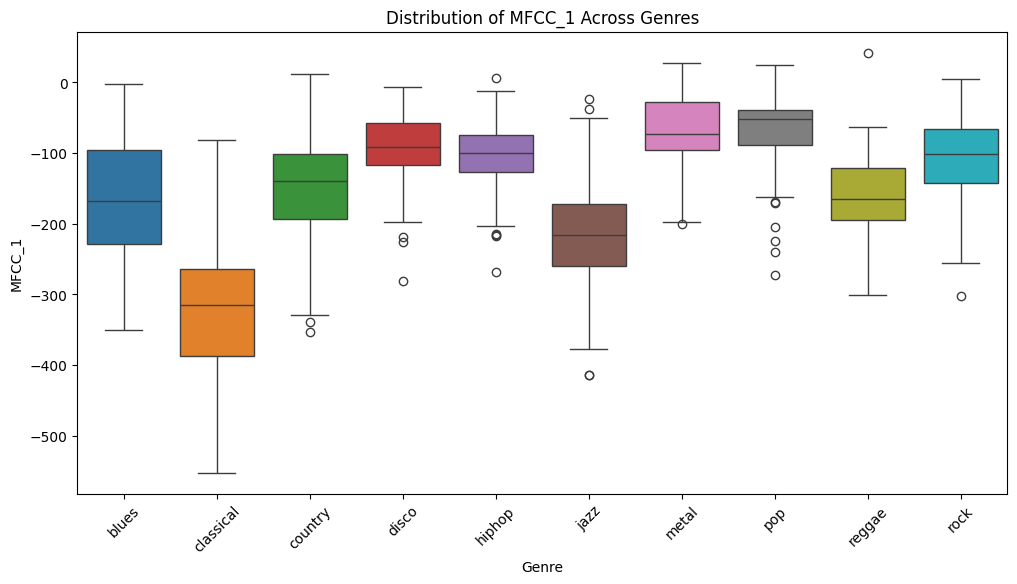

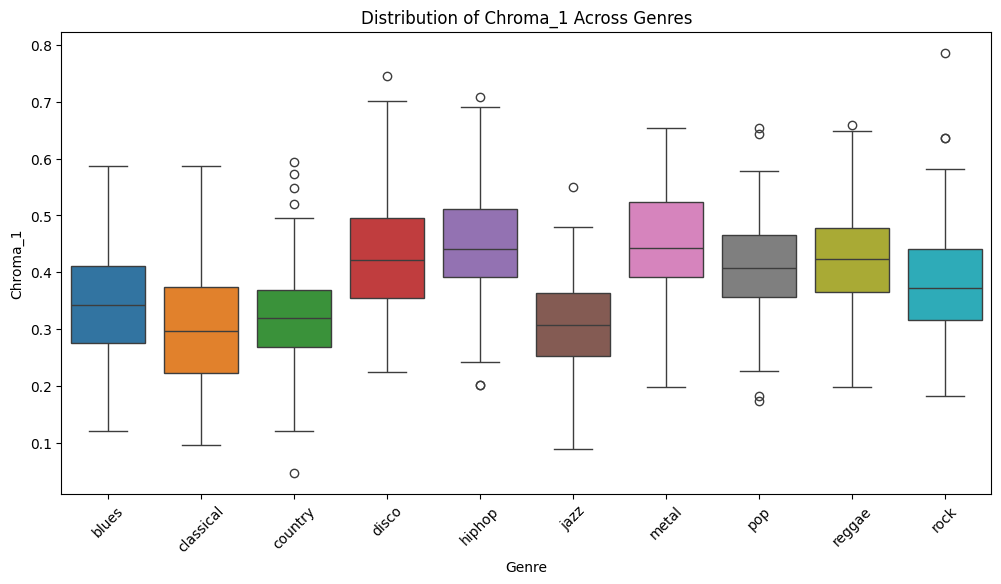

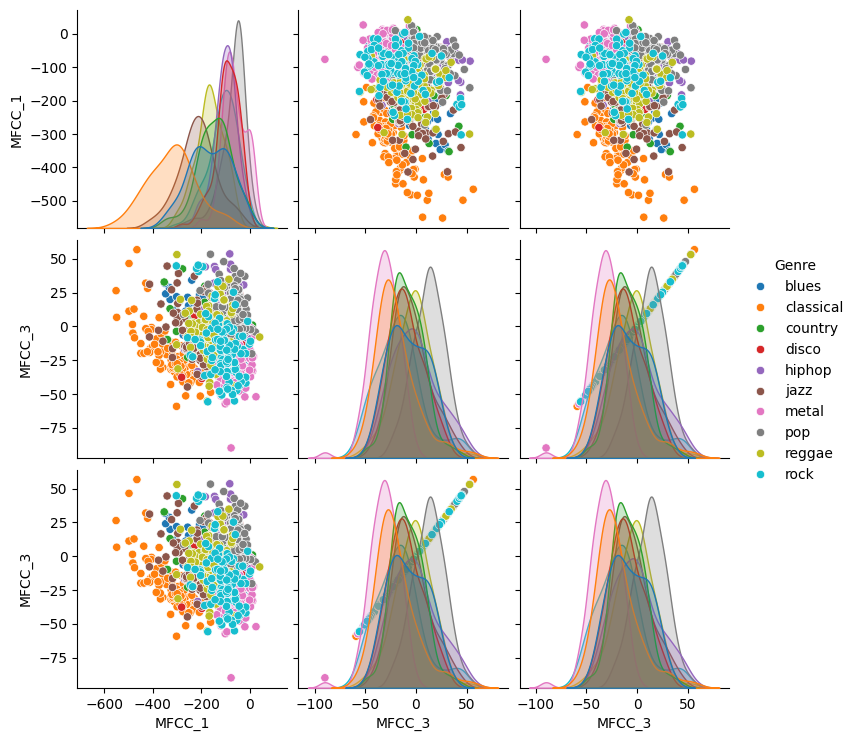

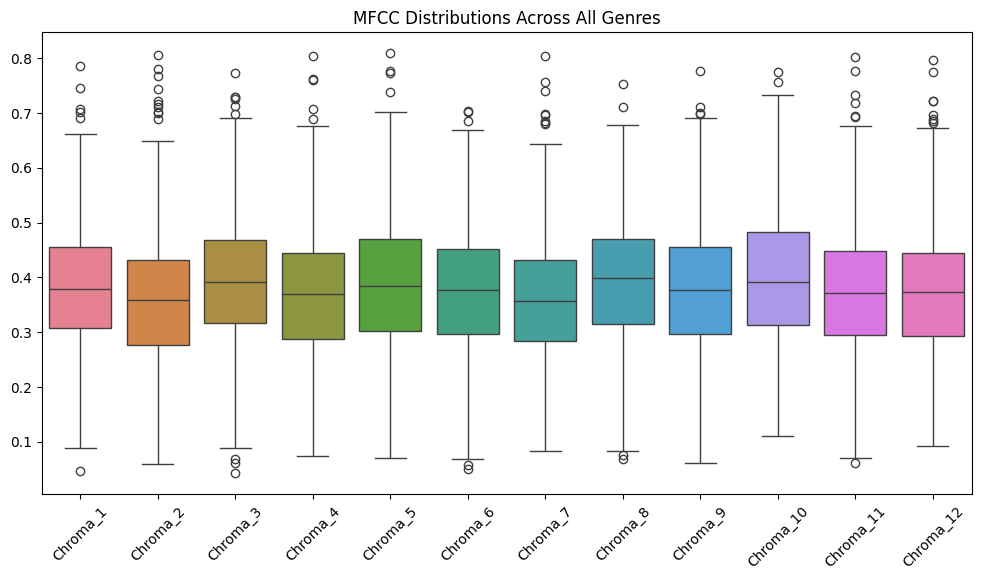

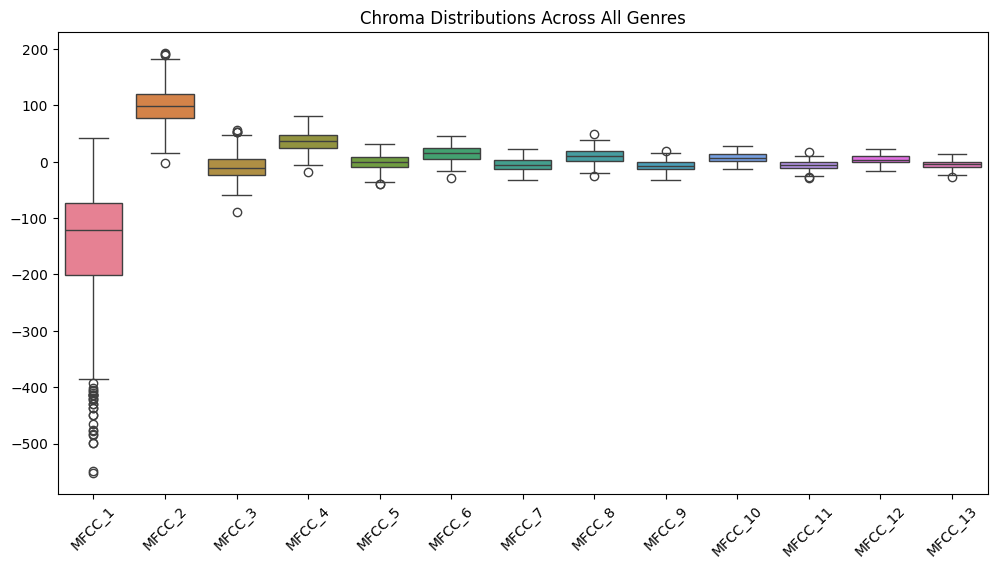

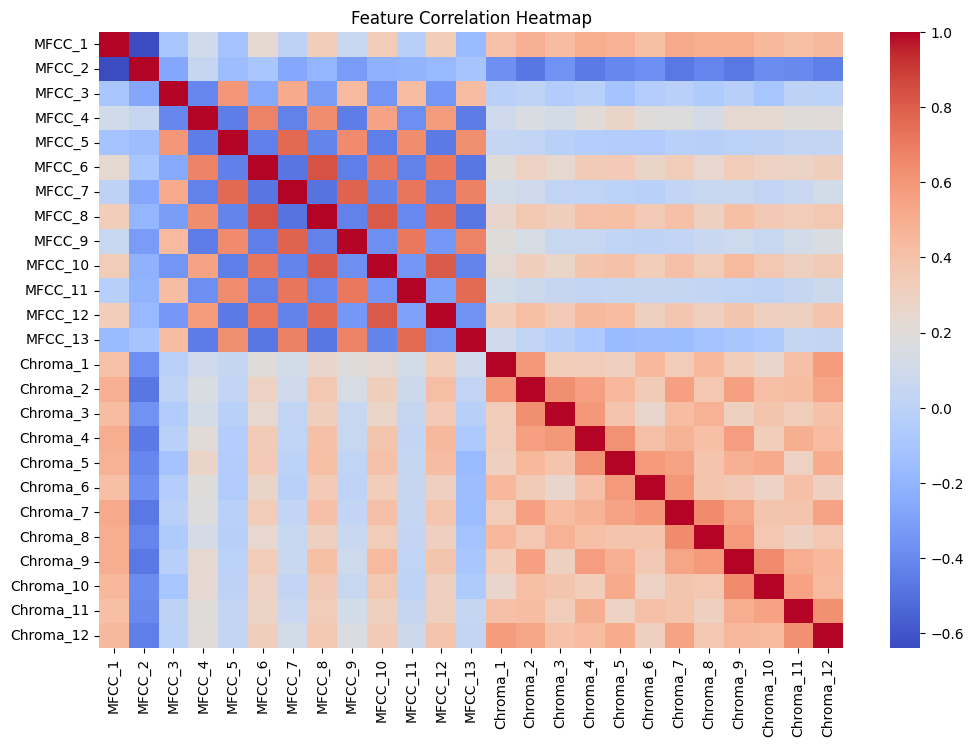

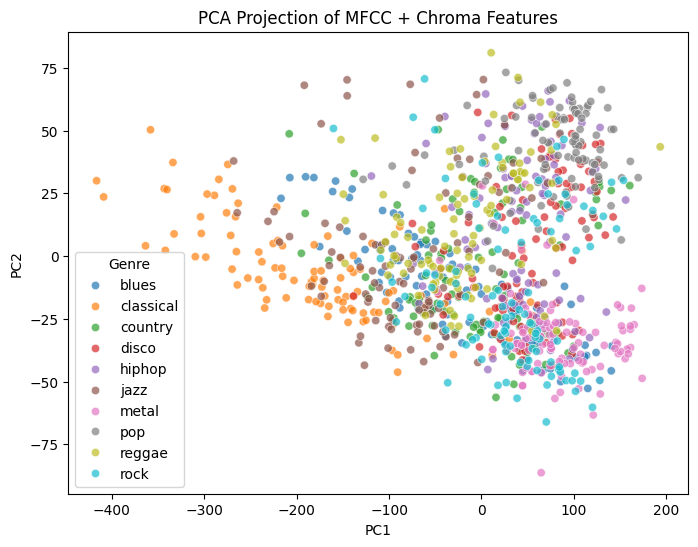

In [6]:
# Visualizations

# Box plots of MFCC and Chroma features to see if there's a discernable difference between genres.
# Only looking at the first feature of each
# Lower-indexed coefficients describe more fundamental aspects of sound and will likely show most difference.
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='MFCC_1', data=df, hue='Genre')
plt.xticks(rotation=45)
plt.title('Distribution of MFCC_1 Across Genres')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Chroma_1', data=df, hue='Genre')
plt.xticks(rotation=45)
plt.title('Distribution of Chroma_1 Across Genres')
plt.show()

# Pairplot for feature correlations
sns.pairplot(df, hue='Genre', vars=['MFCC_1', 'MFCC_3', 'MFCC_3'])
plt.show() # These do not seem to cluster naturally lol. I fear for K-Means

# Checking for outliers with another boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=[f'MFCC_{i+1}' for i in range(13)]))
plt.xticks(rotation=45)
plt.title('MFCC Distributions Across All Genres')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=[f'Chroma_{i+1}' for i in range(12)]))
plt.xticks(rotation=45)
plt.title('Chroma Distributions Across All Genres')
plt.show()

# Checking for correlation to see if we need to drop redundant features
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(columns=['Genre']).corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# Project features into 2D using PCA to see if genres separate naturally
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop(columns=['Genre']))
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Genre'] = df['Genre']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Genre', data=df_pca, alpha=0.7)
plt.title('PCA Projection of MFCC + Chroma Features')
plt.show() # Classical actually seems to distinguish itself pretty well. There's some slight separation with other genres, but most with classical.


# Data Observations
MFCC_1 Across Genres:
- Classical music is particularly distinct. Lower MFCC_1 indicates a smoother or perhaps less percussive spectral shape.
- Pop and Metal have median MFCC_1 values close to 0. Likely due to higher spectral energy in low MFCC components. This aligns with the louder, high-energy sounds common to each genre.
- There is wide variability in many genres. A broad IQR here indicates diverse timbral characteristics which may make it difficult to separate genres using this feature.
- Outliers exist in a few genres. Classical in particular has a few extreme lows, but since it is also the lowest on average, this shouldn't affect classification models too much.
- This feature will most likely be useful in classifying classical music, but may struggle to differentiate other genres, especially due to wide IQR in a few.

Chroma_1 Across Genres:
- Chroma_1 values are much more evenly distributed than MFCC_1.
- Medians do seem a bit varied, but generally wide IQR may again mean this feature will struggle to differentiate genres.
- Will need to keep other Chroma features to enable better discrimination.

MFCC_1-3 Pairplot:
- We once again see that there isn't great separation across our first three MFCC features.
- Classical music stands out, but clusters are otherwise not well defined across these three metrics.
- Observations so far seem to indicate that K-Means will struggle with this classification task.

MFCC and Chroma Distribution Across All Genres:
- Besides a few particularly low Chroma 1 values, it doesn't look like there are many outliers, so I think it's safe to keep all of our data.

Feature Correlation Heatmap:
- There don't appear to be any concerning correlations indicating redundancy across features, so it's probably safe to keep them all. 

PCA Projection of MFCC + Chroma Features:
- We can see a bit more separation here for genres like Metal (in pink), but there's a pretty huge spread across Rock, Hiphop, and Reggae that might confuse classification.

It's clear that the features don't give us an easy visible separability of the genres, so I am now moreso than before expecting the K-Means and Hierarchical Clustering models to struggle. It's still possible that SVM might work with the higher dimensional data.

# K-Means Training
Let's start with k-means. While we expect performance to not be great, it's super easy to train this model. We just need to normalize the features and specify n=10 clusters for the 10 genres we have. In addition, I'll train a K-Medoids model using the alternative distance metric of cosine similarity which may be better for the music features. This process is very similar, just need to add a step to compute cosine similarity but the scikit-learn module takes care of all of that.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn_extra.cluster import KMedoids

In [8]:
X = df.drop(columns=['Genre'])

scaler=StandardScaler()
X_scaled = scaler.fit_transform(X) # K-Means is sensitive to scale, so we normalize features before clustering to not bias towards any one high magnitude feature

# Standard K-Means with Euclidian distance
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Using K-Medoids clustering with cosine-distance.
X_dist = cosine_distances(X_scaled)
kmedoids = KMedoids(n_clusters=10, metric='precomputed', random_state=42)
kmedoids.fit(X_dist)

KMedoids(metric='precomputed', n_clusters=10, random_state=42)

In [9]:
# Save model classified labels to copy of data frame so we can compare later
results_df = pd.DataFrame(df['Genre'])
results_df['KMeans'] = kmeans.labels_
results_df['KMedoids'] = kmedoids.labels_

# Measures how well-separated clusters are. ~1 means good separation, ~0 indicates overlap, Negative means bad clustering
silhouette_kmeans = silhouette_score(X_scaled, kmeans.labels_)
print(f'Silhouette Score: {silhouette_kmeans:.3f}')
silhouette_kmeds = silhouette_score(X_dist, kmedoids.labels_)
print(f'Silhouette Score: {silhouette_kmeds:.3f}')

# Compute accuracy
cluster_to_genre_means = results_df.groupby('KMeans')['Genre'].agg(lambda x: x.mode()[0]) # Most frequent genre per cluster to assign a genre to each cluster
results_df['KMeans_genre'] = results_df['KMeans'].map(cluster_to_genre_means)

accuracy = np.mean(results_df['KMeans_genre'] == results_df['Genre'])
print(f'K-Means Accuracy: {100*accuracy:.3f}%')

cluster_to_genre_meds = results_df.groupby('KMedoids')['Genre'].agg(lambda x: x.mode()[0])
results_df['KMedoids_genre'] = results_df['KMedoids'].map(cluster_to_genre_meds)

accuracy = np.mean(results_df['KMedoids_genre'] == results_df['Genre'])
print(f'K-Medoids Accuracy: {100*accuracy:.3f}%')

Silhouette Score: 0.099
Silhouette Score: 0.133
K-Means Accuracy: 39.500%
K-Medoids Accuracy: 35.700%


# K-Means and K-Medoids Discussion
As predicted, separation into clusters wasn't great. K-Means was able to correctly label 39.5% of all sample tracks. Interestingly, the K-Medoids model using cosine distances was able to build more distinct clusters (as indicated by the higher silhouette score), but actually performed worse at classifying songs. If I were to spend more time and attempt to refine these clustering models, I would go back and investigate different numbers of clusters. It might not be super logical to have a different number of clusters than genres, but genres may be better split into subgroups to allow better separation. An elbow diagram to visualize inertia for models with different numbers of clusters would be useful to do this. I would select a final number of clusters for each model based on the point where adding more clusters stop significantly reducing inertia. However, if a number of clusters different than the number of genres is used, explaining results and clustering decisions would become much more difficult. For now, I'll just move onto our next method

# SVM Training
Training this model will be a little more involved. As a supervised model, we'll need to break our data into a train-test split. I'll also experiment with a few different kernels. The kernels I'll use are as follows:

Linear:
- Works well if features are linearly separable.

Radial Basis Function (RBF):
- Captures complex, non-linear boundaries.

Polynomial:
- Extends decision boundaries in higher dimensions.

Sigmoid:
- Works like a neural network activation function.

I'll approach hyperparameter tuning after looking at initial results from these kernels.

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Linear Kernel Accuracy: 55.500%
              precision    recall  f1-score   support

       blues       0.54      0.65      0.59        20
   classical       0.86      0.90      0.88        20
     country       0.40      0.40      0.40        20
       disco       0.35      0.30      0.32        20
      hiphop       0.47      0.45      0.46        20
        jazz       0.61      0.70      0.65        20
       metal       0.76      0.80      0.78        20
         pop       0.58      0.75      0.65        20
      reggae       0.45      0.50      0.48        20
        rock       0.29      0.10      0.15        20

    accuracy                           0.56       200
   macro avg       0.53      0.55      0.54       200
weighted avg       0.53      0.56      0.54       200



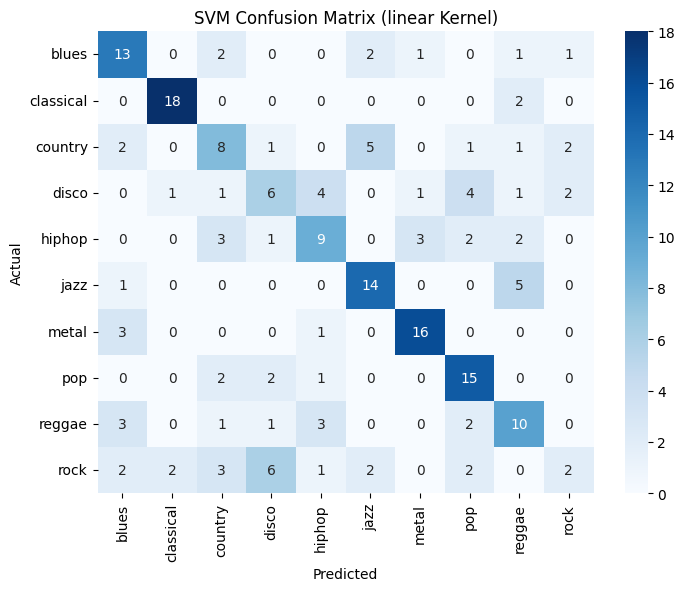

Rbf Kernel Accuracy: 61.000%
              precision    recall  f1-score   support

       blues       0.56      0.50      0.53        20
   classical       0.90      0.95      0.93        20
     country       0.46      0.55      0.50        20
       disco       0.50      0.35      0.41        20
      hiphop       0.48      0.50      0.49        20
        jazz       0.73      0.80      0.76        20
       metal       0.67      0.80      0.73        20
         pop       0.57      0.80      0.67        20
      reggae       0.53      0.45      0.49        20
        rock       0.73      0.40      0.52        20

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.60       200
weighted avg       0.61      0.61      0.60       200



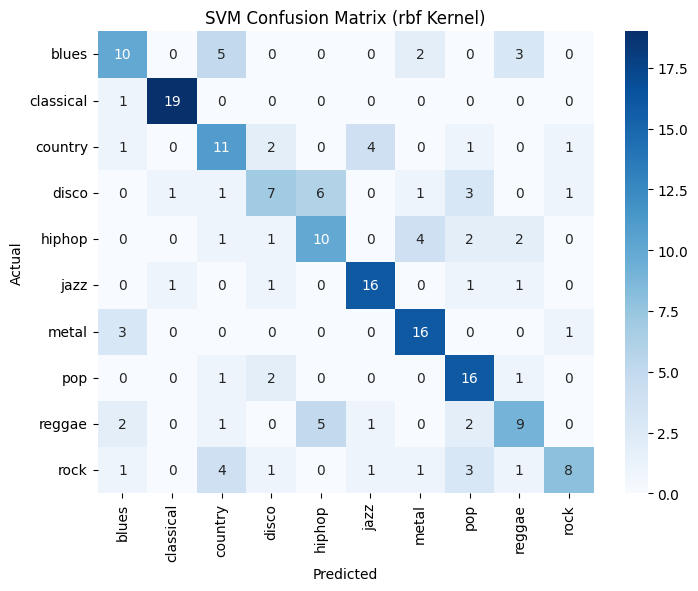

Poly Kernel Accuracy: 57.000%
              precision    recall  f1-score   support

       blues       0.62      0.40      0.48        20
   classical       0.94      0.85      0.89        20
     country       0.41      0.65      0.50        20
       disco       0.33      0.30      0.32        20
      hiphop       0.47      0.40      0.43        20
        jazz       0.86      0.60      0.71        20
       metal       0.88      0.75      0.81        20
         pop       0.73      0.80      0.76        20
      reggae       0.37      0.70      0.48        20
        rock       0.45      0.25      0.32        20

    accuracy                           0.57       200
   macro avg       0.61      0.57      0.57       200
weighted avg       0.61      0.57      0.57       200



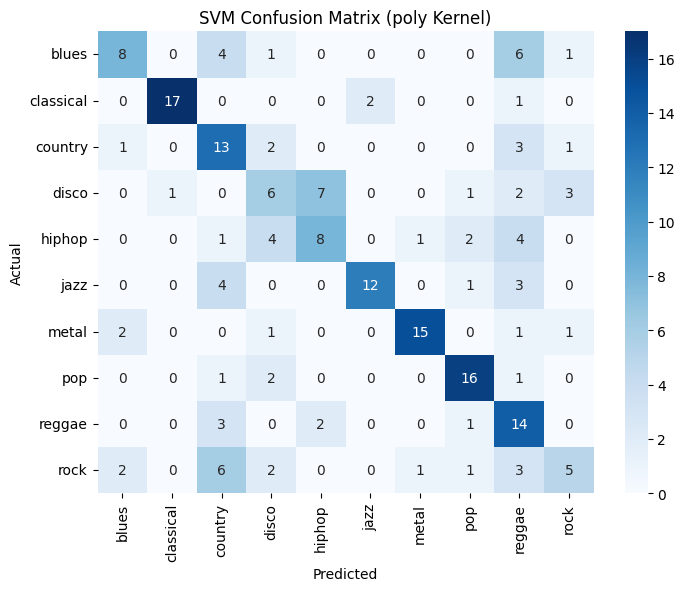

Sigmoid Kernel Accuracy: 47.500%
              precision    recall  f1-score   support

       blues       0.44      0.55      0.49        20
   classical       0.80      0.80      0.80        20
     country       0.43      0.30      0.35        20
       disco       0.23      0.15      0.18        20
      hiphop       0.37      0.35      0.36        20
        jazz       0.48      0.60      0.53        20
       metal       0.50      0.80      0.62        20
         pop       0.48      0.80      0.60        20
      reggae       0.46      0.30      0.36        20
        rock       0.33      0.10      0.15        20

    accuracy                           0.47       200
   macro avg       0.45      0.47      0.45       200
weighted avg       0.45      0.47      0.45       200



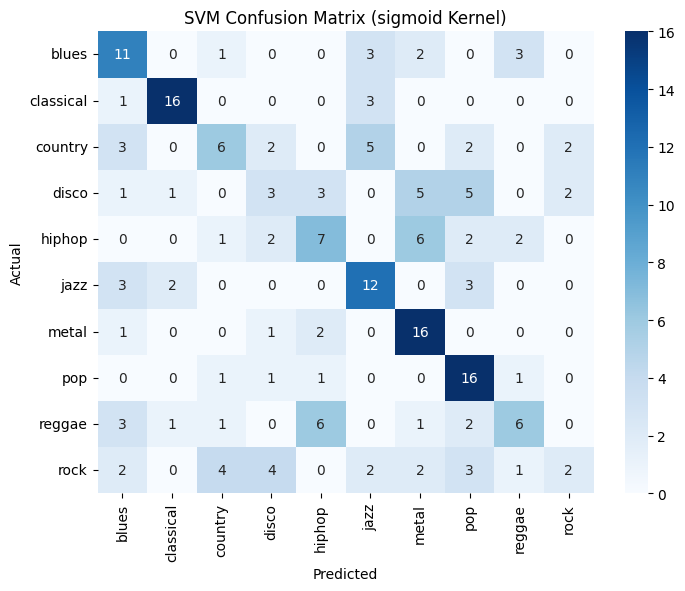

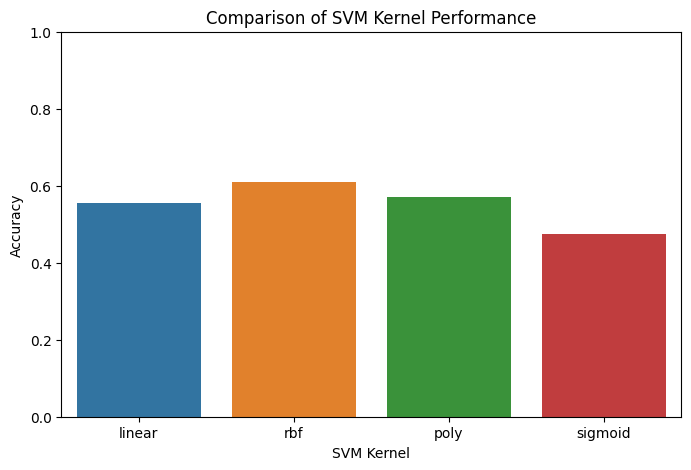

In [11]:
# Already defined this above, but repeating for clarity
X = df.drop(columns=['Genre'])
y = df['Genre']

# Need to normalize features again to avoid biasing towards any one feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = {}

for kernel in kernels:
    svm = SVC(kernel=kernel, C=1, random_state=42)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[kernel] = acc

    print(f'{kernel.capitalize()} Kernel Accuracy: {100*acc:0.3f}%')
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
    plt.title(f'SVM Confusion Matrix ({kernel} Kernel)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), hue=list(results.keys()))
plt.xlabel("SVM Kernel")
plt.ylabel("Accuracy")
plt.title("Comparison of SVM Kernel Performance")
plt.ylim(0, 1)
plt.show()


# SVM Hyperparameter Tuning
Since the RBF kernel performed the best, let's see how far we can take it. There are two parameters I'll play with to try and optimize.

Regularization Parameter (C):
- Higher C: less tolerance for misclassified points. Can increase accuracy but risks overfitting
- Lower C: vice-versa, more tolerance for misclassification but can underfit

Kernel Coefficient (gamma):
- Higher gamma: each point has more influence, making the decision boundary more flexible
- Lower gammaL: again, vice-versa. Makes a smoother boundary but again risks underfitting

I'll run an RBF kernel SVM through a few different C and gamma combinations to evaluate which performs best.

In [12]:
# Define range of hyperparameters to try out
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

svm_rbf = SVC(kernel='rbf')

grid_search = GridSearchCV(svm_rbf,             # The model I'm training
                           param_grid,          # Dict of hyperparameters to test
                           cv=5,                # Cross-validation folds
                           scoring='accuracy',  # Comparison metric
                           n_jobs=-1,           # Use all CPU cores
                           verbose=2)           # Detailed process reporting
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print('Best Accuracy:', grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 10, 'gamma': 0.1}
Best Accuracy: 0.61875


# SVM Discussion
Our final model utilized an RBF kernel with C=10 and gamma=0.1. Our final accuracy of ~62% is quite a lot better than the ~40% accuracy from the K-Means model, but is still not what I would consider a 'good' result. There are a few things here that might explain the poor performance. As a data scientist, the easiest thing to do here is blame my data. After all, 1000 datapoints split across 10 classes isn't actually a very robust sample size in the context of training machine learning models. It may be helpful to do some sort of data augmentation by pitch shifting songs or time stretching, but I don't know how valid those methods are, especially when pitch and tempo are likely critical to genre designation. A larger dataset would likely be very useful. If I were to modify my approach while using this dataset, I think feature selection may be a good starting point. We saw earlier that there was a lot of overlap across MFCC and Chroma features across genres, so adding something like spectral contrast or zero-crossing rate might help differentiate by pitch or rhythmic elements. It may also simply be the case that genres as humans understand them are too interwoven in feature space to define a hyperplane that cleanly separates them.

# Naive Bayes Training
Unlike the earlier two models, there is only really one valid variant of the Naive Bayes to use here. Because our features are continuous numerical features, we'll use a Gaussian Naive Bayes classifier. If we had categorical data or binary features, we'd use a Multinomial or Bernouli model respectively. I don't expect this model to perform as well as the SVM due to the assumption of independence of features which may not be valid here. The major advantage here is that this model should be very fast to train and easily interpretable.

In [13]:
from sklearn.naive_bayes import GaussianNB

Naive Bayes Accuracy: 47.500%
              precision    recall  f1-score   support

       blues       0.38      0.30      0.33        20
   classical       0.75      0.90      0.82        20
     country       0.47      0.35      0.40        20
       disco       0.33      0.05      0.09        20
      hiphop       0.42      0.25      0.31        20
        jazz       0.50      0.55      0.52        20
       metal       0.45      0.85      0.59        20
         pop       0.40      0.95      0.57        20
      reggae       0.56      0.25      0.34        20
        rock       0.43      0.30      0.35        20

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.43       200
weighted avg       0.47      0.47      0.43       200



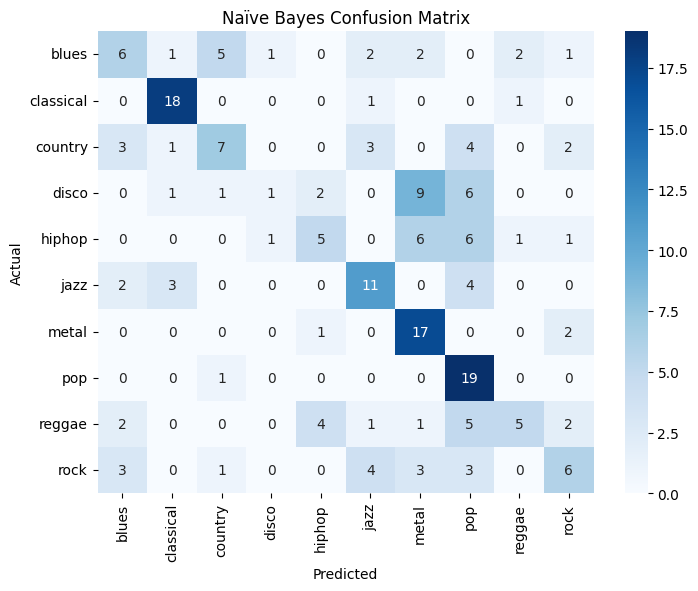

In [14]:
# Again repeating this for clarity
X = df.drop(columns=['Genre'])
y = df['Genre']

# Here we normalize because a GaussianNB assumes a normal distribution so scaling should improve performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

nb_acc = accuracy_score(y_test, y_pred)
print(f'Naive Bayes Accuracy: {100*nb_acc:.3f}%')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title('Naïve Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Naive Bayes Discussion
It looks like the results followed predictions pretty closely. The accuracy of ~48% outperforms the K-Means model, but falls short of the SVM. The most likely explanation for this is dependence among certain features. As we can see in the confusion matrix, genres such as Blues, Disco, Hiphop, and Reggae were more or less randomly assigned as the other genres.

# Random Forest
I didn't initially plan to run either of these classifiers, but I'm interested in seeing what model outside of deep learning will give me the best result because our best so far has been disappointing. I'm not going to do any tuning here, just want to see if I can squeeze out a better result with either of these models.

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(rf_acc*100)

61.0


Looks like with some default parameters the Random Forest landed a respectable 61% accuracy. Just shy of the best SVM I trained, but still not good enough to merit hyperparameter tuning.

# Overall Discussion
In this project, I trained a K-Means, K-Medoids, RBF SVM, and Gaussian Naive Bayes models to classify music by genre using MFCC and Chroma features extracted from 100 songs from each of 10 genres. Unfortunately, no model was particularly successful at this task with the best model being a Support Vector Machine utilizing an RBF kernel with slightly tuned hyperparameters coming in at 61.88% accuracy. The next best was the Naive Bayes at ~48% and the unsupervised clustering models coming in at the high 30s% each.

There are a few explanations for poor performance across the board. Suspect number one is the training data size. Given the complexity of something such as a musical genre, it would be useful to have more than 100 samples of each. Another issue I faced was with feature selection. It is difficult to derive numeric features from music that can be used in a machine learning task, and extracting common features such as MFCCs and Chromas didn't actually provide differentiable metrics for the models.

If I were to revisit this project, I would apply deep learning methods that are more powerful.

# Addendum
The following is outside the scope of this project, it's just me playing around with a simple multilayer perceptron. Maybe if I get CUDA set up one day I'll run a more involved architecture like a CNN or LSTM.

In [19]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Genre'])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(label_encoder.classes_), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"MLP Test Accuracy: {test_acc:.3f}")

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1951 - loss: 2.2401 - val_accuracy: 0.3750 - val_loss: 1.7987
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3799 - loss: 1.6773 - val_accuracy: 0.4500 - val_loss: 1.4751
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4572 - loss: 1.4330 - val_accuracy: 0.5150 - val_loss: 1.3760
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5172 - loss: 1.2887 - val_accuracy: 0.5650 - val_loss: 1.2964
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6277 - loss: 1.0879 - val_accuracy: 0.6000 - val_loss: 1.2457
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6320 - loss: 1.0730 - val_accuracy: 0.6250 - val_loss: 1.2087
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 1.0161 - val_accuracy: 0.6000 - val_loss: 1.2138
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6849 - loss: 0.9487 - val_accuracy: 0.5750 - val_loss:

Lol. Accuracy of 0.59. 

In [21]:
from tensorflow.keras import layers, regularizers

model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),

    keras.layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(len(label_encoder.classes_), activation="softmax")
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Optimized MLP Test Accuracy: {test_acc:.3f}")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1697 - loss: 8.8048 - val_accuracy: 0.3500 - val_loss: 7.4455
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3022 - loss: 7.7208 - val_accuracy: 0.3750 - val_loss: 7.1371
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3902 - loss: 7.2543 - val_accuracy: 0.4350 - val_loss: 6.9082
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4051 - loss: 6.8846 - val_accuracy: 0.4500 - val_loss: 6.6649
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4177 - loss: 6.6184 - val_accuracy: 0.4300 - val_loss: 6.4249
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4801 - loss: 6.3541 - val_accuracy: 0.4900 - val_loss: 6.1704
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4801 - loss: 6.0599 - val_accuracy: 0.4600 - val_loss: 5.9603
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4850 - loss: 5.8064 - val_accuracy: 0.4300 - val_loss:

Eh. At this point I'm throwing in the towel. Not enough data, unsatisfactory feature set.